In [1]:
# default_exp inferno

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# INFERNO loss

> API details.

In [3]:
#hide
from nbdev.showdoc import *

In [4]:
from pytorch_inferno.model_wrapper import ModelWrapper
from pytorch_inferno.callback import *
from pytorch_inferno.data import get_paper_data
from pytorch_inferno.plotting import *
from pytorch_inferno.inference import *
from pytorch_inferno.utils import *
from pytorch_inferno.inferno import *

from fastcore.all import partialler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from typing import *
from collections import OrderedDict
from fastcore.all import store_attr
from abc import abstractmethod

import torch.nn.functional as F
from torch import optim, autograd, nn, Tensor
import torch
from torch.distributions import Normal

In [5]:
bs = 2000
data, test = get_paper_data(200000, bs=bs, n_test=1000000)

In [6]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)
model = ModelWrapper(net)

In [7]:
%%time
model.fit(200, data=data, opt=partialler(optim.SGD,lr=1e-6), loss=None,
          cbs=[PaperInferno(float_r=True, float_l=True, alpha_aux=[Normal(0,2), Normal(0,2)], float_b=True, b_aux=Normal(1000,100)),
               LossTracker(),SaveBest('weights/best_ie4.h5'),EarlyStopping(10)])

1: Train=1655.936137084961 Valid=971.9936413574219
2: Train=759.7977899169922 Valid=685.628374633789
3: Train=676.5568557739258 Valid=770.0616033935547
4: Train=616.5499044799805 Valid=612.3249523925781
5: Train=577.2624838256836 Valid=596.5664288330078
6: Train=560.8420623779297 Valid=565.7110998535156
7: Train=548.3731503295899 Valid=559.9101647949219
8: Train=514.2079681396484 Valid=558.5456134033203
9: Train=518.2867294311524 Valid=529.9420764160157
10: Train=511.2441650390625 Valid=524.2600451660156
11: Train=502.26902099609373 Valid=506.7028521728516
12: Train=483.35285614013674 Valid=489.73298706054686
13: Train=496.1157257080078 Valid=486.9799993896484
14: Train=464.79114227294923 Valid=471.14662841796877
15: Train=455.9293603515625 Valid=480.18162536621094
16: Train=447.44385986328126 Valid=457.1601885986328
17: Train=439.6057748413086 Valid=459.266572265625
18: Train=439.7900717163086 Valid=439.43915283203125
19: Train=434.8647869873047 Valid=435.0459729003906
20: Train=423.9

In [9]:
model.save('weights/Inferno_Test_exact_bm4.h5')

In [10]:
model.load('weights/Inferno_Test_exact_bm4.h5')

# Results

## BM 0

In [8]:
preds = model._predict_dl(test, pred_cb=InfernoPred())

In [11]:
df = pd.DataFrame({'pred':preds})
df['gen_target'] = test.dataset.y
df.head()

,pred,gen_target
0,3,1.0
1,9,1.0
2,5,1.0
3,3,1.0
4,9,1.0


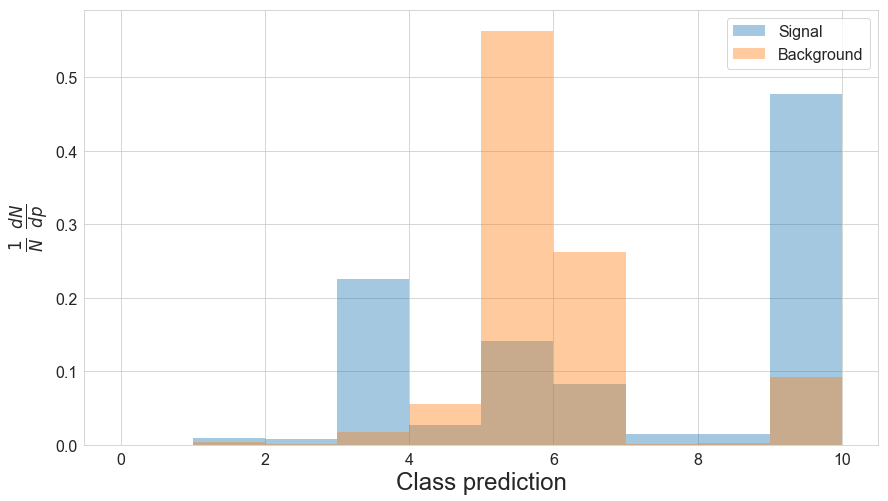

In [12]:
plot_preds(df, bin_edges=np.linspace(0,10,11))

In [13]:
bin_preds(df)

In [14]:
df.head()

,pred,gen_target,pred_bin
0,3,1.0,3
1,9,1.0,9
2,5,1.0,5
3,3,1.0,3
4,9,1.0,9


In [15]:
f_s,f_b = get_shape(df,1),get_shape(df,0)

In [16]:
f_s.sum(), f_b.sum()

(tensor(1.), tensor(1.))

In [17]:
f_s, f_b

(tensor([2.0000e-13, 9.7600e-03, 7.7060e-03, 2.2528e-01, 2.6694e-02, 1.4073e-01,
         8.2176e-02, 1.5026e-02, 1.4570e-02, 4.7806e-01]),
 tensor([2.0000e-13, 3.4780e-03, 7.9400e-04, 1.7610e-02, 5.5790e-02, 5.6379e-01,
         2.6252e-01, 1.1160e-03, 2.4800e-03, 9.2424e-02]))

In [18]:
asimov = (50*f_s)+(1000*f_b)

In [19]:
asimov, asimov.sum()

(tensor([2.1000e-10, 3.9660e+00, 1.1793e+00, 2.8874e+01, 5.7125e+01, 5.7083e+02,
         2.6663e+02, 1.8673e+00, 3.2085e+00, 1.1633e+02]), tensor(1050.))

In [20]:
n = 1050
x = np.linspace(20,80,61)
y = np.zeros_like(x)
for i,m in enumerate(x):
    pois = torch.distributions.Poisson((m*f_s)+(1000*f_b))
    y[i] = -pois.log_prob(asimov).sum()
y

array([24.22519112, 24.08008003, 23.94077873, 23.80778694, 23.680233  ,
       23.55853462, 23.44254303, 23.33196831, 23.22662163, 23.12652397,
       23.03228951, 22.94284821, 22.85855484, 22.77967644, 22.70540237,
       22.63629532, 22.57194519, 22.51266861, 22.45801926, 22.40800667,
       22.36259079, 22.32167053, 22.28549767, 22.2536602 , 22.2261467 ,
       22.20326233, 22.18492508, 22.16994286, 22.15965843, 22.15348625,
       22.15182877, 22.15376091, 22.15956497, 22.16951752, 22.18349648,
       22.2013092 , 22.22290993, 22.24827576, 22.27734756, 22.31037712,
       22.34705162, 22.38711739, 22.43059921, 22.47832108, 22.52898407,
       22.58336067, 22.64113617, 22.70213509, 22.76684952, 22.83444405,
       22.90565109, 22.98010063, 23.05764389, 23.13870621, 23.22254944,
       23.30989456, 23.40013885, 23.49331284, 23.59019089, 23.68928528,
       23.79184341])

In [21]:
y_tf2 = np.array([31.626238,31.466385,31.313095,31.166267,31.025808,30.891619,30.76361
,30.641693,30.525778,30.415783,30.31162,30.213215,30.120483,30.033348
,29.951736,29.875574,29.804789,29.739307,29.679066,29.623993,29.574026
,29.5291,29.489151,29.454117,29.423939,29.398558,29.377914,29.361954
,29.35062,29.343859,29.341618,29.343842,29.350483,29.36149,29.376812
,29.396404,29.420216,29.448202,29.480318,29.516518,29.556757,29.600994
,29.649185,29.70129,29.757267,29.817076,29.88068,29.948036,30.019108
,30.093859,30.17225,30.25425,30.339819,30.42892,30.521524,30.617598
,30.7171,30.820007,30.926281,31.035892,31.148808], dtype='float32')

In [22]:
y_tf2-y_tf2.min()

array([2.2846203e+00, 2.1247673e+00, 1.9714775e+00, 1.8246498e+00,
       1.6841908e+00, 1.5500011e+00, 1.4219933e+00, 1.3000755e+00,
       1.1841602e+00, 1.0741653e+00, 9.7000313e-01, 8.7159729e-01,
       7.7886581e-01, 6.9173050e-01, 6.1011887e-01, 5.3395653e-01,
       4.6317101e-01, 3.9768982e-01, 3.3744812e-01, 2.8237534e-01,
       2.3240852e-01, 1.8748283e-01, 1.4753342e-01, 1.1249924e-01,
       8.2321167e-02, 5.6940079e-02, 3.6296844e-02, 2.0336151e-02,
       9.0026855e-03, 2.2411346e-03, 0.0000000e+00, 2.2239685e-03,
       8.8653564e-03, 1.9872665e-02, 3.5194397e-02, 5.4786682e-02,
       7.8598022e-02, 1.0658455e-01, 1.3870049e-01, 1.7490005e-01,
       2.1513939e-01, 2.5937653e-01, 3.0756760e-01, 3.5967255e-01,
       4.1564941e-01, 4.7545815e-01, 5.3906250e-01, 6.0641861e-01,
       6.7749023e-01, 7.5224113e-01, 8.3063316e-01, 9.1263199e-01,
       9.9820137e-01, 1.0873032e+00, 1.1799068e+00, 1.2759800e+00,
       1.3754826e+00, 1.4783897e+00, 1.5846634e+00, 1.6942749e

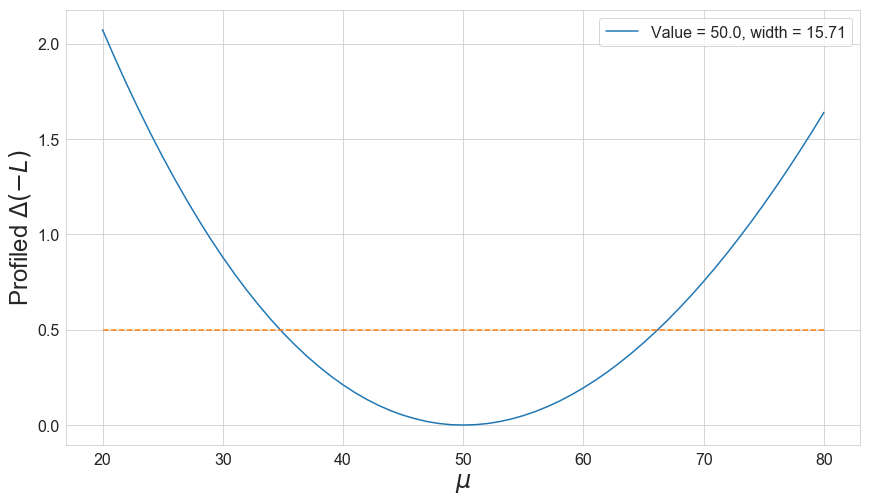

In [23]:
plot_likelihood(y-y.min())

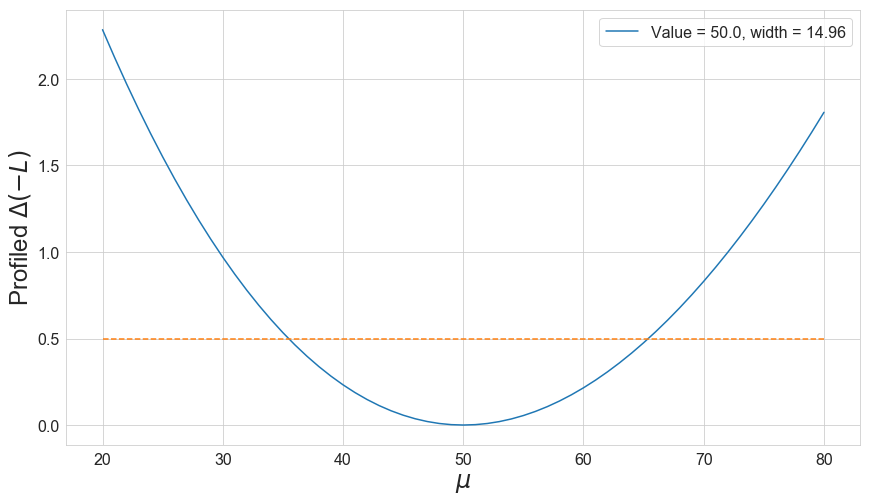

In [24]:
plot_likelihood(y_tf2-y_tf2.min())

# Nuisances - via interpolation

In [25]:
bkg = test.dataset.x[test.dataset.y.squeeze() == 0]
assert len(bkg) == 500000

In [26]:
b_shapes = get_paper_syst_shapes(bkg, df, model=model, pred_cb=InfernoPred())

Running: r=-0.2


Running: r=0


Running: r=0.2


Running: l=2.5


Running: l=3


Running: l=3.5


In [27]:
df

,pred,gen_target,pred_bin,pred_-0.2_3,pred_-0.2_3_bin,pred_0_3,pred_0_3_bin,pred_0.2_3,pred_0.2_3_bin,pred_0_2.5,pred_0_2.5_bin,pred_0_3.5,pred_0_3.5_bin
0,3,1.0,3,3,3,3,3,3,3,3,3,3,3
1,9,1.0,9,9,9,9,9,9,9,9,9,9,9
2,5,1.0,5,5,5,5,5,5,5,5,5,5,5
3,3,1.0,3,3,3,3,3,3,3,3,3,3,3
4,9,1.0,9,9,9,9,9,9,9,9,9,9,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,9,0.0,9,9,9,9,9,9,9,9,9,9,9
999996,5,0.0,5,5,5,5,5,5,5,5,5,5,5
999997,6,0.0,6,6,6,6,6,6,6,6,6,6,6
999998,5,0.0,5,5,5,5,5,5,5,5,5,5,5


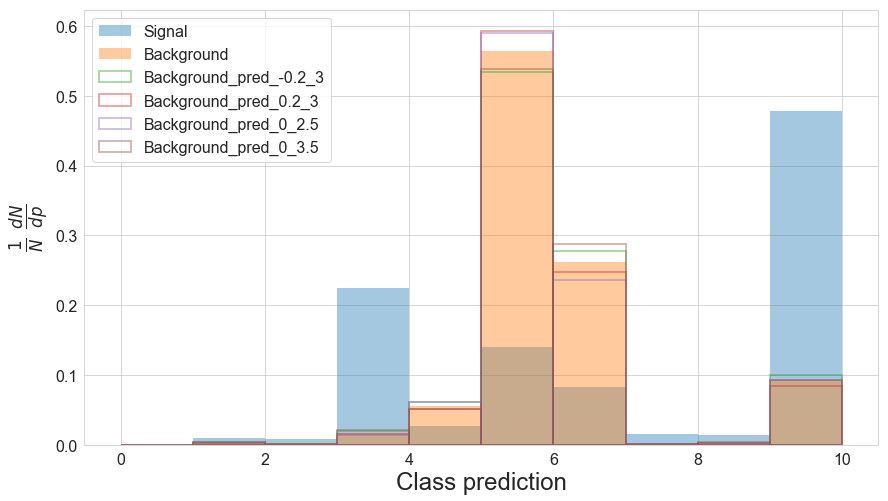

In [28]:
plot_preds(df, pred_names=['pred', 'pred_-0.2_3', 'pred_0.2_3', 'pred_0_2.5', 'pred_0_3.5'], bin_edges=np.linspace(0,10,11))

tensor([2.0000e-13, 3.2060e-03, 3.6200e-04, 1.5940e-02, 6.6386e-02, 5.5958e-01,
        2.5189e-01, 6.3800e-04, 1.6080e-03, 1.0039e-01])
tensor([2.0000e-13, 3.5220e-03, 8.0400e-04, 1.9112e-02, 6.0882e-02, 5.3369e-01,
        2.7773e-01, 1.1680e-03, 2.5480e-03, 1.0055e-01])
tensor([2.0000e-13, 3.6380e-03, 1.3460e-03, 2.2292e-02, 5.6170e-02, 5.0800e-01,
        3.0261e-01, 1.8720e-03, 3.7340e-03, 1.0034e-01])
tensor([2.0000e-13, 3.1620e-03, 3.5200e-04, 1.4438e-02, 6.1294e-02, 5.8968e-01,
        2.3668e-01, 5.8600e-04, 1.5400e-03, 9.2264e-02])
tensor([2.0000e-13, 3.4780e-03, 7.9400e-04, 1.7610e-02, 5.5790e-02, 5.6379e-01,
        2.6252e-01, 1.1160e-03, 2.4800e-03, 9.2424e-02])
tensor([2.0000e-13, 3.5940e-03, 1.3360e-03, 2.0790e-02, 5.1078e-02, 5.3810e-01,
        2.8740e-01, 1.8200e-03, 3.6660e-03, 9.2216e-02])
tensor([2.0000e-13, 2.9080e-03, 3.3800e-04, 1.2716e-02, 5.6248e-02, 6.1941e-01,
        2.2195e-01, 5.5800e-04, 1.4060e-03, 8.4468e-02])
tensor([2.0000e-13, 3.2240e-03, 7.8000e-0

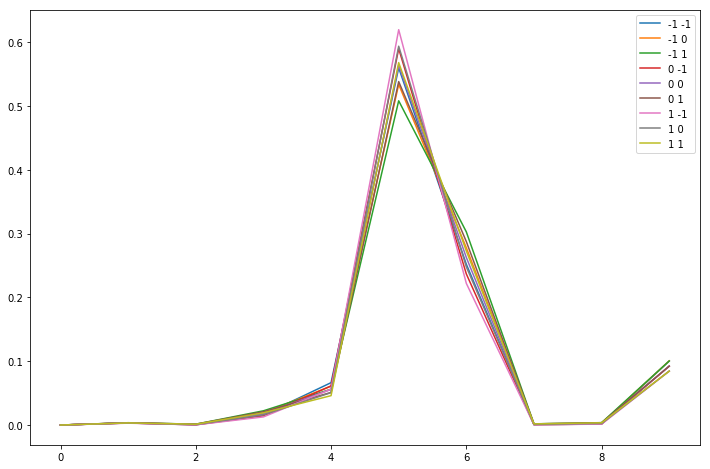

In [29]:
fig = plt.figure(figsize=(12,8))
for r in [-1,0,1]:
    for l in [-1,0,1]:
        alpha = Tensor((r,l))[None,:]
        s = interp_shape(alpha, **b_shapes).squeeze()
        print(s)
        plt.plot(s, label=f'{r} {l}')
plt.legend()

# Newton

In [30]:
profiler = partialler(calc_profile, n=1050, mu_scan=torch.linspace(20,80,61), true_mu=50)

## BM 1
r free, l fixed

In [31]:
bm1_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                            ('f_b_up',  b_shapes['f_b_up'][0][None,:]),
                            ('f_b_dw',  b_shapes['f_b_dw'][0][None,:])])

In [32]:
bm1_b_shapes['f_b_up'].shape

torch.Size([1, 10])

In [33]:
nll = profiler(f_s=f_s, n_steps=100, **bm1_b_shapes)

In [34]:
nll = to_np(nll)

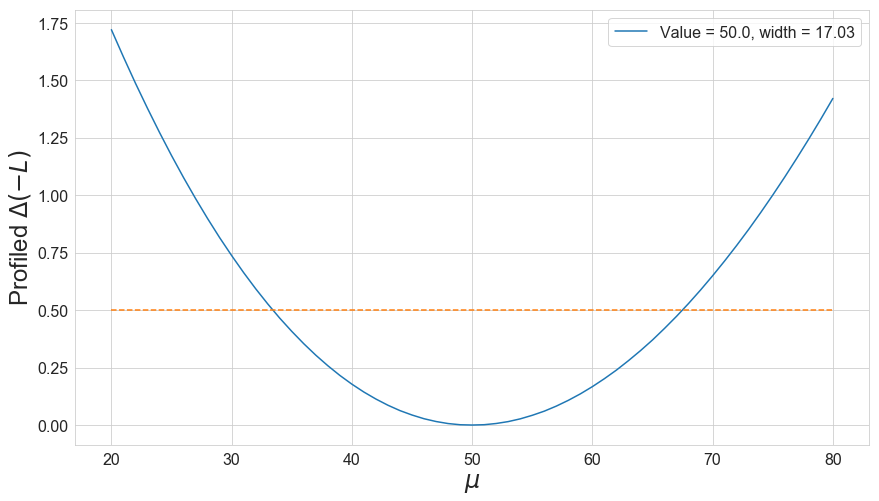

In [35]:
plot_likelihood(nll-nll.min())

## BM 1l
r fixed, l free

In [36]:
bm1l_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                             ('f_b_up',  b_shapes['f_b_up'][1][None,:]),
                             ('f_b_dw',  b_shapes['f_b_dw'][1][None,:])])

In [37]:
nll = profiler(f_s=f_s, n_steps=100, **bm1l_b_shapes)

In [38]:
nll = to_np(nll)

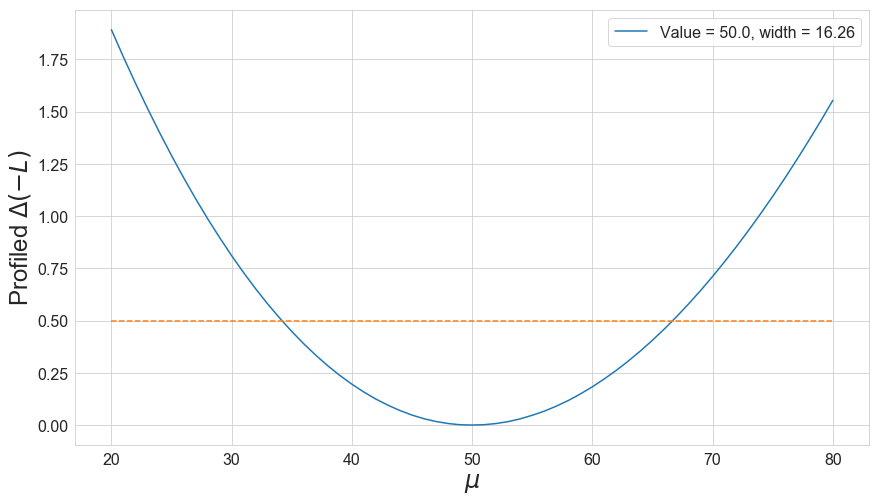

In [39]:
plot_likelihood(nll-nll.min())

## BM 2

In [40]:
nll = profiler(f_s=f_s, n_steps=100, **b_shapes)

In [41]:
nll = to_np(nll)

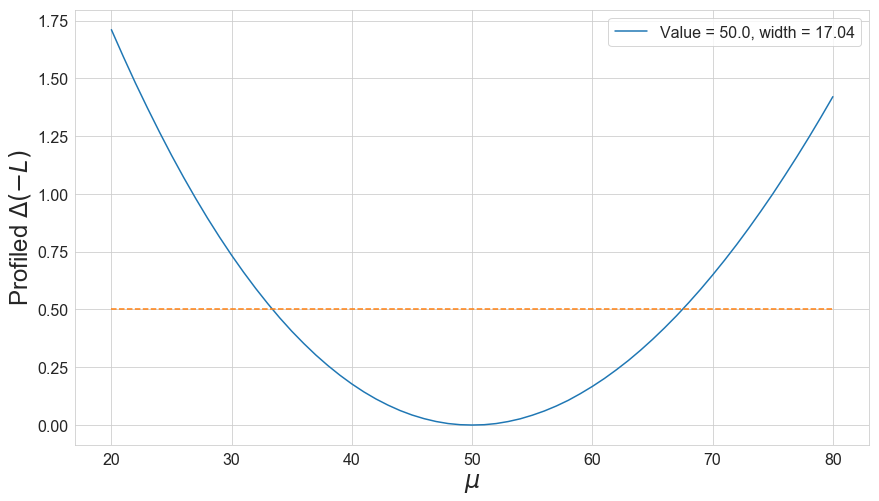

In [42]:
plot_likelihood(nll-nll.min())

## BM 3

In [43]:
alpha_aux = [Normal(0,2), Normal(0,2)]

In [44]:
nll = profiler(f_s=f_s, n_steps=100, alpha_aux=alpha_aux, **b_shapes)

In [45]:
nll = to_np(nll)

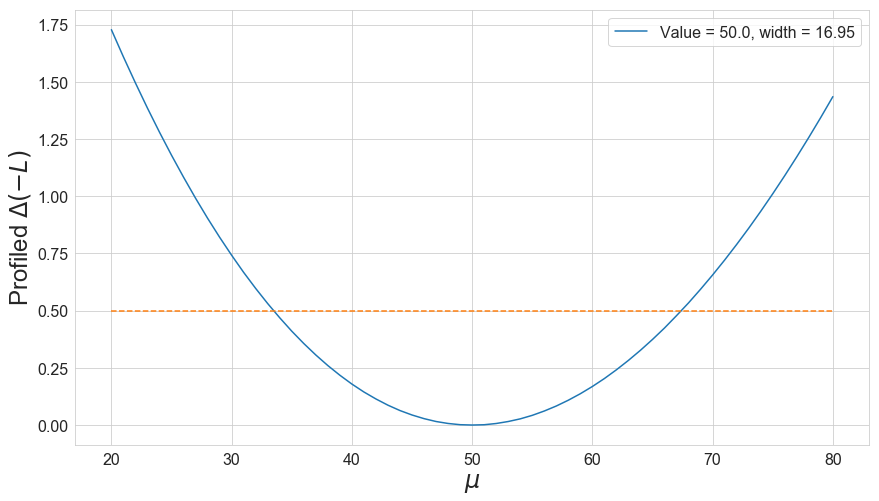

In [46]:
plot_likelihood(nll-nll.min())

## BM 4

In [47]:
alpha_aux = [Normal(0,2), Normal(0,2)]

In [48]:
nll = profiler(f_s=f_s, n_steps=100, alpha_aux=alpha_aux, float_b=True, b_aux=Normal(1000,100), **b_shapes)

Linear regime: Mu 20.0, alpha tensor([-0.3538,  0.0848, 25.4731])
Linear regime: Mu 21.0, alpha tensor([-0.3419,  0.0807, 24.5493])
Linear regime: Mu 22.0, alpha tensor([-0.3300,  0.0766, 23.6313])
Linear regime: Mu 23.0, alpha tensor([-0.3181,  0.0727, 22.7189])
Linear regime: Mu 24.0, alpha tensor([-0.3062,  0.0689, 21.8122])
Linear regime: Mu 25.0, alpha tensor([-0.2943,  0.0651, 20.9110])
Linear regime: Mu 26.0, alpha tensor([-0.2825,  0.0615, 20.0152])
Linear regime: Mu 27.0, alpha tensor([-0.2706,  0.0580, 19.1249])
Linear regime: Mu 28.0, alpha tensor([-0.2587,  0.0545, 18.2399])
Linear regime: Mu 29.0, alpha tensor([-0.2469,  0.0512, 17.3601])
Linear regime: Mu 30.0, alpha tensor([-0.2350,  0.0479, 16.4856])
Linear regime: Mu 31.0, alpha tensor([-0.2232,  0.0448, 15.6162])
Linear regime: Mu 32.0, alpha tensor([-0.2114,  0.0417, 14.7519])
Linear regime: Mu 33.0, alpha tensor([-0.1995,  0.0387, 13.8926])
Linear regime: Mu 34.0, alpha tensor([-0.1877,  0.0358, 13.0384])
Linear reg

In [49]:
nll = to_np(nll)

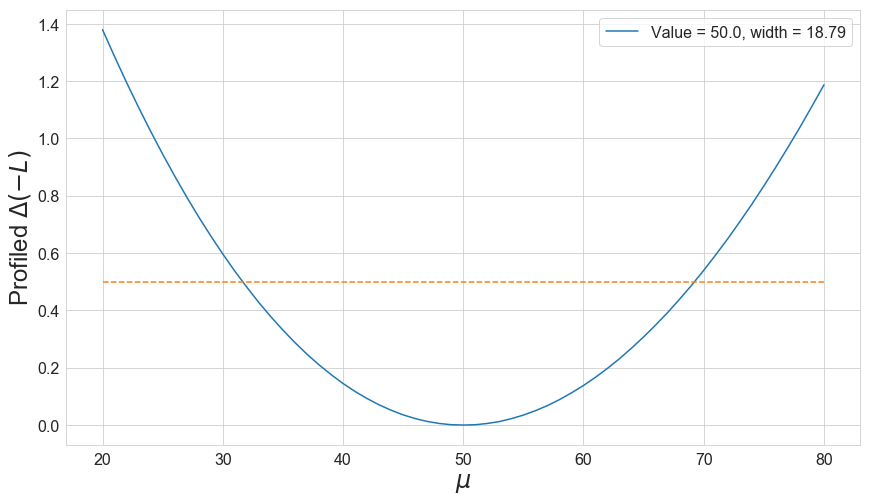

In [50]:
plot_likelihood(nll-nll.min())